In [ ]:
!pip install -q py_vncorenlp stop_words underthesea

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 34.6 MB/s eta 0:00:00


In [ ]:
!gdown 1GiQblDsjwHCLxP1zpcifVlS3zRZ09ICc

Downloading...
From: https://drive.google.com/uc?id=1GiQblDsjwHCLxP1zpcifVlS3zRZ09ICc
To: /content/uehnews-corpus.txt
100% 10.5M/10.5M [00:00<00:00, 39.6MB/s]


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words
stop_words_vi = get_stop_words('vi')
import py_vncorenlp
from tqdm import tqdm
import networkx as nx
from collections import Counter

import pandas as pd
from nltk import ngrams
from gensim.models import Word2Vec
from wordcloud import WordCloud

import sys
import importlib
import collections
import itertools
import matplotlib.pyplot as plt
import logging

# Word Segmentation

In [ ]:
py_vncorenlp.download_model(save_dir='/content/')
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/')

In [ ]:
input_file_path = '/content/uehnews-corpus.txt'
output_file_path = '/content/ueh-corpus-segmented.txt'

with open(input_file_path, 'r', encoding='utf-8') as file:
    text = file.read()

segmented_text = []
with tqdm(total=len(text.split('\n')), desc="Segmenting") as pbar:
    for line in text.split('\n'):
        segmented_line = rdrsegmenter.word_segment(line)
        segmented_text.append(segmented_line)
        pbar.update(1)

with open(output_file_path, 'w', encoding='utf-8') as file:
    for line in segmented_text:
        for sentence in line:
            file.write(sentence + '\n')

print("Segmentation completed. Segmented text saved to", output_file_path)

Segmenting: 100%|██████████| 133503/133503 [01:25<00:00, 1566.83it/s]


Segmentation completed. Segmented text saved to /content/ueh-corpus-segmented.txt


In [ ]:
def count_unique_words(file_path):
    unique_words = set()
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            words = line.strip().split()
            unique_words.update(words)
    return len(unique_words)

file_path = output_file_path  # Provide the path to your text file
num_unique_words = count_unique_words(file_path)
print("Number of unique words in the file:", num_unique_words)

Number of unique words in the file: 35407


In [ ]:
import pandas as pd

with open(file_path, "r", encoding="utf-8") as file:
    content = file.readlines()

df = pd.DataFrame({"row": content})
df = df[df["row"].str.strip() != ""]
df.reset_index(drop=True, inplace=True)
print(df)

                                                     row
0      Ngày 12/10/2014 , tại Hội_trường A116 , Cơ_sở ...
1      Đến tham_dự ngày hội có đại_diện các ngân_hàng...
2      Ngày hội là cơ_hội để các bạn sinh_viên khoa N...
3      Có_mặt tại buổi lễ , đại_diện các ngân_hàng và...
4      phó giáo_sư tiến_sĩ Trần_Hoàng_Ngân – Phó Bí_t...
...                                                  ...
40548  18 Doanh_nhân và tiêu_dùng :   “ Kết_nối cộng_...
40549  19 Thời báo Ngày_nay :  UEH Sharing – Career_F...
40550  20 Thế_giới tiếp_thị : UEH Sharing – Career_Fa...
40551  21 Đài_truyền_hình Kỹ_thuật_số ( VTC ) : Khởi_...
40552                                          Chia_sẻ\n

[40553 rows x 1 columns]


In [ ]:
def transform_row(row):
  '''
  basic text preprocessing:
  - remove punctuation
  - remove vietnamese stopwords
  '''
  if isinstance(row, str):
      row = re.sub(r'[^\w\s]', '', row)
      words = row.split()
      filtered_words = [word for word in words if word.lower() not in stop_words_vi]
      row = " ".join(filtered_words).strip()
  return row

df["row"] = df.row.apply(transform_row)
df.head(10)

,row
0,12102014 Hội_trường A116 Cơ_sở 59C Nguyễn_Đình...
1,tham_dự hội đại_diện ngân_hàng thương_mại công...
2,hội cơ_hội sinh_viên khoa Ngân_hàng có_thể hoạ...
3,Có_mặt lễ đại_diện ngân_hàng công_ty chứng_kho...
4,phó giáo_sư tiến_sĩ Trần_Hoàng_Ngân Phó Bí_thư...
5,Bùi_Thị_Sim Phó trưởng Văn_phòng đại_diện NHTM...
6,phó giáo_sư tiến_sĩ Trần_Hoàng_Ngân tặng hoa q...
7,Đại_diện Ban_Giám_hiệu lãnh_đạo khoa Ngân_hàng...
8,Sinh_viên Đặng_Thị_Lan_Anh lớp NH CLC K37 đai ...
9,phó giáo_sư tiến_sĩ Phạm_Văn_Năng Nguyên Hiệu_...


# Create Unigram and Bigram

In [ ]:
%%timeit
def ngram(string, n=1):
    gram_str = list(ngrams(string.split(), n))
    return [ " ".join(gram).lower() for gram in gram_str ]

df["unigram"] = df.row.apply(lambda t: ngram(t, 1))
df["bigram"] = df.row.apply(lambda t: ngram(t, 2))

1.12 s ± 193 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from nltk import bigrams
terms_bigram = [list(bigrams(tweet)) for tweet in df["unigram"]]
terms_bigram[0]

[('12102014', 'hội_trường'),
 ('hội_trường', 'a116'),
 ('a116', 'cơ_sở'),
 ('cơ_sở', '59c'),
 ('59c', 'nguyễn_đình_chiểu'),
 ('nguyễn_đình_chiểu', 'khoa_ngân'),
 ('khoa_ngân', 'hàng'),
 ('hàng', 'trường'),
 ('trường', 'đại_học'),
 ('đại_học', 'kinh_tế'),
 ('kinh_tế', 'thành_phố'),
 ('thành_phố', 'hồ_chí_minh'),
 ('hồ_chí_minh', 'tổ_chức'),
 ('tổ_chức', 'hội'),
 ('hội', 'hướng_nghiệp'),
 ('hướng_nghiệp', 'khoa'),
 ('khoa', 'ngân_hàng'),
 ('ngân_hàng', '11'),
 ('11', '2014')]

In [ ]:
# Flatten list of bigrams in clean tweets
# In tất cả các giá trị có trong terms_bigram có thể lặp lại lần lượt
bigrams = list(itertools.chain(*terms_bigram))
# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)
bigram_counts.most_common(25)

[(('giáo_sư', 'tiến_sĩ'), 5259),
 (('thành_phố', 'hồ_chí_minh'), 4354),
 (('trường', 'đại_học'), 4030),
 (('phó', 'giáo_sư'), 2822),
 (('đại_học', 'kinh_tế'), 2642),
 (('kinh_tế', 'thành_phố'), 2640),
 (('phó', 'hiệu_trưởng'), 2037),
 (('trưởng', 'phòng'), 1343),
 (('sinh_viên', 'ueh'), 1293),
 (('ảnh', 'phòng'), 1262),
 (('tiến_sĩ', 'nguyễn_đông_phong'), 1260),
 (('chương_trình', 'đào_tạo'), 1145),
 (('phó', 'trưởng'), 1136),
 (('hiệu_trưởng', 'ueh'), 1053),
 (('chủ_tịch', 'hội_đồng'), 986),
 (('hội_đồng', 'trường'), 913),
 (('đổi_mới', 'sáng_tạo'), 837),
 (('nghiên_cứu', 'khoa_học'), 833),
 (('đa', 'ngành'), 828),
 (('hồ_chí_minh', 'ueh'), 827),
 (('tân', 'sinh_viên'), 804),
 (('đ', 'c'), 790),
 (('phát_triển', 'bền_vững'), 763),
 (('một_số', 'hình_ảnh'), 716),
 (('tiến_sĩ', 'sử_đình_thành'), 708)]

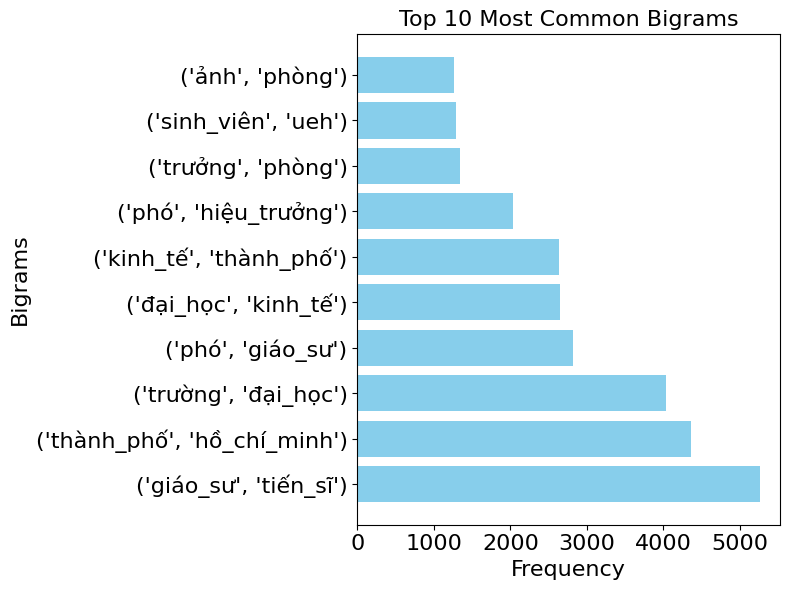

In [ ]:
bigrams = list(itertools.chain(*terms_bigram))
bigram_counts = collections.Counter(bigrams)
top_25_bigrams = bigram_counts.most_common(25)
bigram_labels, counts = zip(*top_25_bigrams[:10])

plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.barh(range(len(bigram_labels)), counts, color='skyblue')
plt.yticks(range(len(bigram_labels)), bigram_labels,fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Frequency',fontsize=16)
plt.ylabel('Bigrams',fontsize=16)
plt.title('Top 10 Most Common Bigrams',fontsize=16)
plt.tight_layout()
plt.savefig('bigram_hist.pdf')
plt.show()

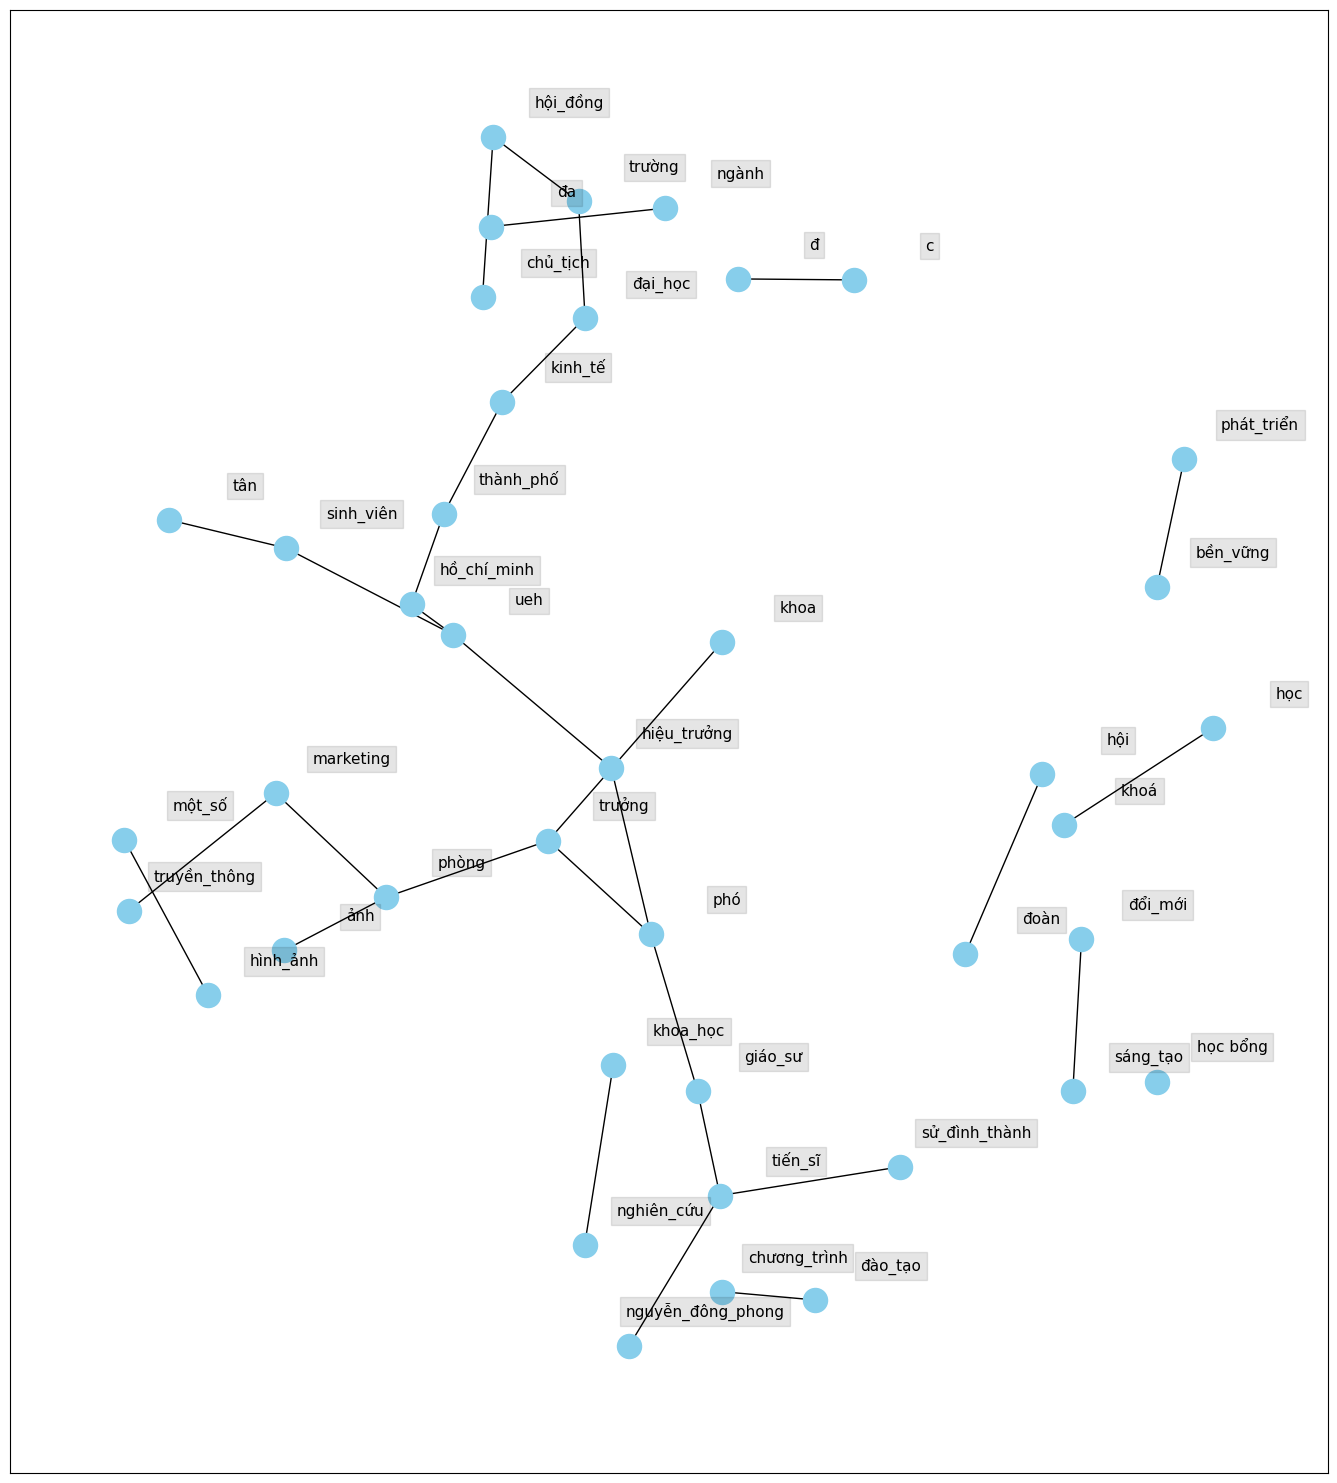

In [ ]:
bigram_df = pd.DataFrame(bigram_counts.most_common(30),columns=['unigram', 'count'])

d = bigram_df.set_index('unigram').T.to_dict('records')
G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("học bổng", weight=100) # Thêm node sad tỏng G

fig, ax = plt.subplots(figsize=(17, 19))
pos = nx.spring_layout(G, k=10)

nx.draw_networkx(G, pos,
                 edge_color='black',
                 node_color='skyblue',
                 with_labels = False,
                 ax=ax)

for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='black', alpha=0.10),
            horizontalalignment='center', fontsize=11)
plt.savefig('wordnet.pdf')
plt.show()

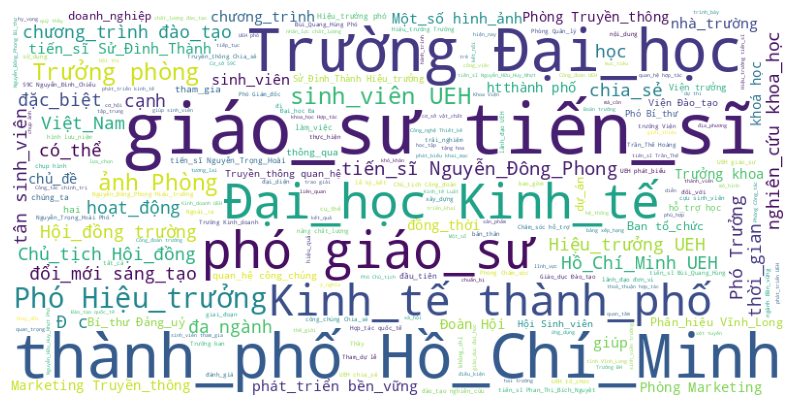

In [ ]:
text = " ".join(df['row'])
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      colormap='viridis',
                      stopwords=None).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordcloud.pdf')
plt.show()

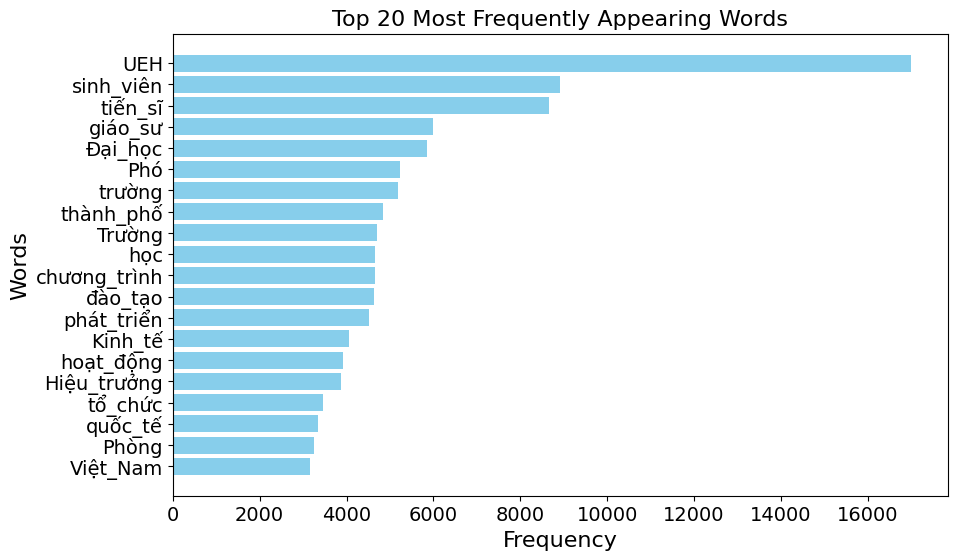

In [ ]:
text = " ".join(df['row'])
words = text.split()
word_counts = Counter(words)
top_20_words = word_counts.most_common(20)
top_words, word_freqs = zip(*top_20_words)

# Plot the top 20 words
plt.figure(figsize=(10, 6))
plt.barh(top_words, word_freqs, color='skyblue')
plt.xlabel('Frequency',fontsize=16)
plt.ylabel('Words',fontsize=16)
plt.title('Top 20 Most Frequently Appearing Words',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.savefig('word-freq.pdf')
plt.show()

In [ ]:
import collections
all_words = []
for line in list(df['row']): #Chia chuỗi thành các đơn từ
    words = line.split()
    for word in words:
        all_words.append(word.lower())

collections.Counter(all_words).most_common(10)#In ra 10 từ phổ biến nhất

[('ueh', 16996),
 ('sinh_viên', 10407),
 ('trường', 9898),
 ('tiến_sĩ', 8968),
 ('đại_học', 8364),
 ('phó', 8063),
 ('giáo_sư', 6429),
 ('kinh_tế', 5885),
 ('chương_trình', 5828),
 ('đào_tạo', 5799)]

# Word2Vec

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
train_data = df.unigram.tolist()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
model = Word2Vec(train_data, vector_size=100, window=4, min_count=3, workers=1, sg=2)
model.wv.key_to_index

{'ueh': 0,
 'sinh_viên': 1,
 'trường': 2,
 'tiến_sĩ': 3,
 'đại_học': 4,
 'phó': 5,
 'giáo_sư': 6,
 'kinh_tế': 7,
 'chương_trình': 8,
 'đào_tạo': 9,
 'thành_phố': 10,
 'phòng': 11,
 'phát_triển': 12,
 'học': 13,
 'hồ_chí_minh': 14,
 'chia_sẻ': 15,
 'hoạt_động': 16,
 'hiệu_trưởng': 17,
 'tổ_chức': 18,
 'trưởng': 19,
 'quốc_tế': 20,
 'nghiên_cứu': 21,
 'việt_nam': 22,
 'thi': 23,
 'thạc_sĩ': 24,
 'ban': 25,
 'hợp_tác': 26,
 'hội': 27,
 'tham_gia': 28,
 'viện': 29,
 'lễ': 30,
 'chủ_tịch': 31,
 'thực_hiện': 32,
 'đoàn': 33,
 'ngành': 34,
 'ảnh': 35,
 'lãnh_đạo': 36,
 'học_tập': 37,
 'bền_vững': 38,
 'hỗ_trợ': 39,
 'quản_lý': 40,
 'tham_dự': 41,
 'cơ_sở': 42,
 'phát_biểu': 43,
 'đơn_vị': 44,
 'kinh_doanh': 45,
 'giáo_dục': 46,
 'trao': 47,
 'doanh_nghiệp': 48,
 'công_nghệ': 49,
 'khoa': 50,
 'nhà_trường': 51,
 'khoá': 52,
 'khoa_học': 53,
 'truyền_thông': 54,
 'chất_lượng': 55,
 'công_tác': 56,
 '2': 57,
 'có_thể': 58,
 'giảng_viên': 59,
 'thầy': 60,
 'giải': 61,
 'hội_đồng': 62,
 'giúp': 63

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words_np = []
words_label = []
for word in model.wv.key_to_index.keys():
    words_np.append(model.wv[word])
    words_label.append(word)

pca = PCA(n_components=2)
pca.fit(words_np)
reduced = pca.transform(words_np)

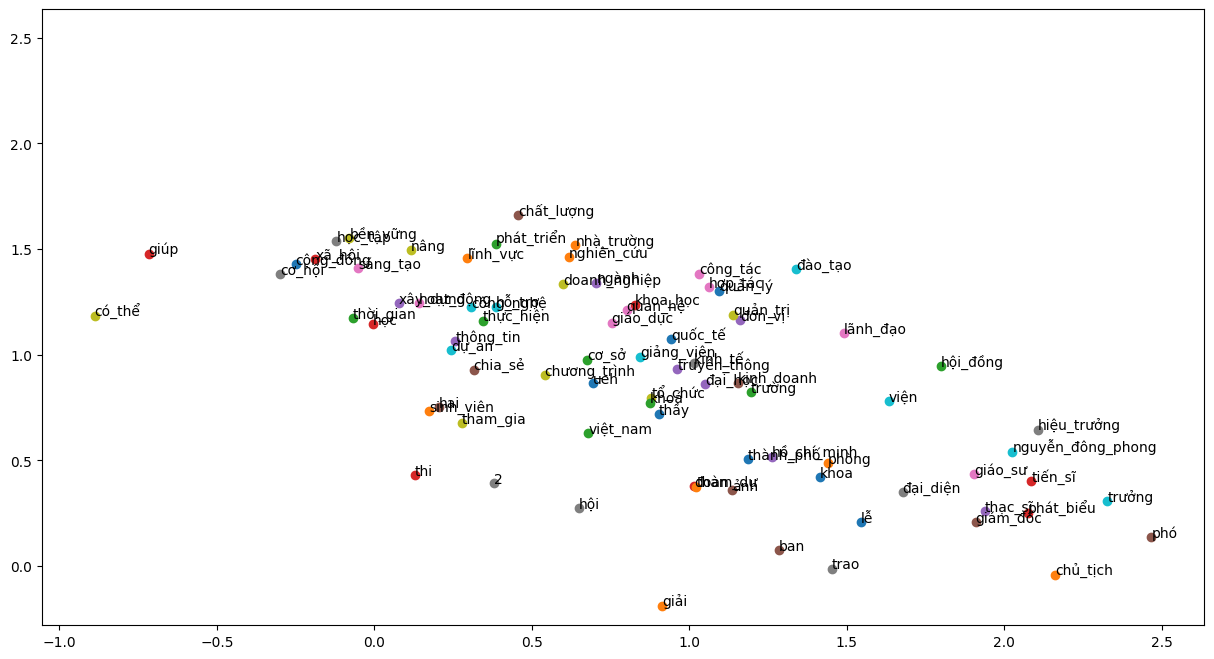

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)

for index, vec in enumerate(reduced):
    if index < 80:
        x, y = vec[0], vec[1]
        plt.scatter(x, y)
        plt.annotate(words_label[index], xy=(x, y))

plt.gca().set_aspect('auto', adjustable='box')
plt.gca().set_ylim(plt.gca().get_ylim()[0], plt.gca().get_xlim()[1])
plt.savefig('word2vec.pdf')
plt.show()

In [ ]:
model.wv.similar_by_word("khoa_học")

[('nckh', 0.7374832034111023),
 ('hàn_lâm', 0.6590604782104492),
 ('nghiên_cứu', 0.6510237455368042),
 ('chuyển_giao', 0.6360408663749695),
 ('kỷ_yếu', 0.6170056462287903),
 ('đẩy_mạnh', 0.6117073893547058),
 ('bàn_thảo', 0.6085929274559021),
 ('iii', 0.6077832579612732),
 ('xuất_bản', 0.6076390743255615),
 ('kĩ_thuật', 0.5991487503051758)]

# NER

In [ ]:
from underthesea import ner

def extract_names(text):
    names = []
    for entity in ner(text):
        if entity[3] == 'B-PER':
            names.append(entity[0])
    return names

with open("/content/uehnews-corpus.txt", "r", encoding="utf-8") as file:
    text = file.read()

names = extract_names(text)
name_counts = Counter(names)